# PREDICTING IMMUNIZATION DROP-OUTS

**Context:** Although vaccination rates have increased globally over the last twenty years — largely
due to efforts to ensure vaccines are stocked at convenient points of care even in remote locations
— they have plateaued in the last decade. This is largely attributable to children who drop out of
their vaccination schedule, i.e., do not receive all their required vaccines, despite access. Delayed
vaccination puts many children at risk and often requires costly vaccination campaigns to resolve.

**Problem Statement:** Imagine you are working with an organization that runs health clinics in
Botswana. They want to be able to send health workers to follow-up with children who have not yet
received all 4 doses of OPV and 3 doses of DPT at 4 months of life. They cannot individually follow-
up with all children, so your job is to help them target their intervention by predicting which children
will not become vaccinated by 6 months without intervention. Therefore, you can use all
information; for example, which vaccines the child received, up until 4 months after the child is
born.

# MODELING

## Part 1: Baseline Solution

In this, I implement baseline solution using Linear regression model 

In [59]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.metrics import mean_squared_error


In [52]:
#setting mlflow
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("immunization_project")

<Experiment: artifact_location='./mlruns/2', experiment_id='2', lifecycle_stage='active', name='immunization_project', tags={}>

In [53]:
#Reading prepared data 
data = pd.read_csv("~/Elvis/macro-eyes/ML_Assignment/Data/data_clean1.csv", index_col=[0])

In [31]:
data

,pat_id,fac_id,dob,gender,long,lat,region,district,im_date,successful,reason_unsuccesful,DTP,OPV,full_dose
1,2,89.0,2019-11-12,f,24.877556,-18.370709,Chobe,Chobe,2019-11-12,True,0,0,1,0
2,3,161.0,2019-11-03,m,25.249672,-20.490189,Central,Tutume,2019-11-03,True,0,1,2,0
3,4,168.0,2019-04-17,f,25.579269,-21.412151,Central,Lethlakane,2019-06-01,True,0,3,4,1
4,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,2018-12-24,True,0,2,4,0
5,6,142.0,2018-09-06,f,26.241089,-20.298571,Central,Tutume,2018-09-06,True,0,3,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,49995,221.0,2018-01-26,f,27.470027,-21.435094,Central,Serowe,2018-02-26,True,0,2,4,0
48838,49996,191.0,2019-06-17,f,28.551843,-22.495365,Central,Tuli,2019-06-17,True,0,2,3,0
48840,49998,173.0,2018-10-09,f,22.709613,-20.463382,North-West,Ngamiland West,2018-10-17,True,0,3,4,1
48841,49999,333.0,2018-08-26,m,23.356211,-20.074906,North-West,Ngamiland East,2018-08-26,True,0,3,4,1


In [54]:
data.full_dose.value_counts()

0    23957
1    17827
Name: full_dose, dtype: int64

In [55]:
#Splitting data using train_test_split method from sklearn-learn library
train, df_val = train_test_split(data, test_size=0.2)

In [56]:
df_test, df_valid = train_test_split(df_val, test_size=0.5) #splitting further to get test and validation sets

In [57]:
#Save train,val and test datasets as pickle files
train.to_pickle("~/Elvis/macro-eyes/ML_Assignment/Data/immun_train.pkl")
df_valid.to_pickle("~/Elvis/macro-eyes/ML_Assignment/Data/immun_valid.pkl")
df_test.to_pickle("~/Elvis/macro-eyes/ML_Assignment/Data/immun_test.pkl")

In [36]:
#checking on the datatypes of our columns
data.dtypes

pat_id                  int64
fac_id                float64
dob                    object
gender                 object
long                  float64
lat                   float64
region                 object
district               object
im_date                object
successful               bool
reason_unsuccesful     object
DTP                     int64
OPV                     int64
full_dose               int64
dtype: object

In [38]:
categorical = ['dob','gender','region','district','im_date','successful','reason_unsuccesful'] # categorical columns
data[categorical] = data[categorical].astype(str)
numerical = ['fac_id','pat_id','DTP','OPV','lat','long']

dv = DictVectorizer() # Transforms lists of feature-value mappings to vectors

train_dicts = train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [39]:
target = 'full_dose' #Target variable
y_train = train[target].values
y_val = df_val[target].values

In [40]:
lr = LinearRegression() # Creating linear regression object
lr.fit(X_train, y_train)  # Training the model using the training sets

y_pred = lr.predict(X_val) # Make predictions using the testing set

mean_squared_error(y_val, y_pred, squared=False) # The root mean squared error

0.37015916128670107

/home/david/.virtualenvs/ML_Assignment-QMq97krE/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


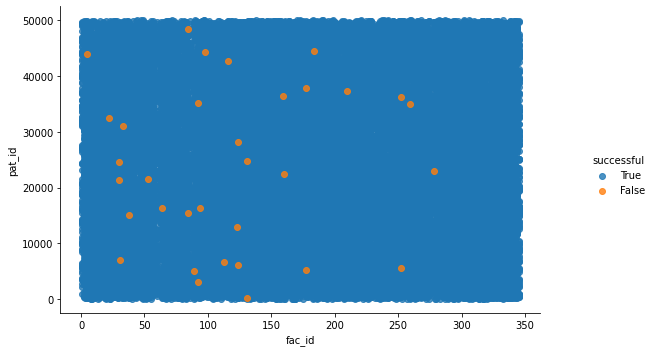

In [15]:
sns.lmplot('fac_id', 'pat_id', data, hue='successful', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

The root mean squared error(rmse) of our baseline solution is **0.37**


## Tracking our baseline solution with [Mlflow](https://mlflow.org/)

In [41]:
with mlflow.start_run():

    mlflow.set_tag("model", "Linear Regression") #setting a tag on a run
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [42]:
print(rmse)

0.37015916128670107


## Predicting using XGboost model

Predicting using XGBoost Regressor

This is our baseline solution with XGboost regressor model

In [43]:
with mlflow.start_run():

    mlflow.set_tag("model", "XGBoost_baseline") #setting a tag on a run
    
    xg_boost = xgb.XGBRegressor()
    xg_boost=xg_boost.fit(X_train, y_train)

    y_pred = xg_boost.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [44]:
print(rmse)

6.4388093135118056e-06


The root mean squared error for XGboost baseline model is **0.0000064**, next we will seek to improve the model through hyper-parameter optimization

### Hyper-parameter Optimization using [Hyperopt](http://hyperopt.github.io/hyperopt/)

In [60]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from IPython.display import Image

In [48]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [50]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [51]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[21:35:16] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:0.45464                           
[1]	validation-rmse:0.41339                           
[2]	validation-rmse:0.37589                           
[3]	validation-rmse:0.34179                           
[4]	validation-rmse:0.31078                           
[5]	validation-rmse:0.28259                           
[6]	validation-rmse:0.25695                           
[7]	validation-rmse:0.23364                           
[8]	validation-rmse:0.21244                           
[9]	validation-rmse:0.19317                           
[10]	validation-rmse:0.17565                          
[11]	validation-rmse:0.15971                          
[12]	validation-rmse:0.14522                          
[13]	validation-rmse:0.13205                          
[14]	validation-rmse:0.12007                          
[15]	validation-rmse:0.10918                          
[

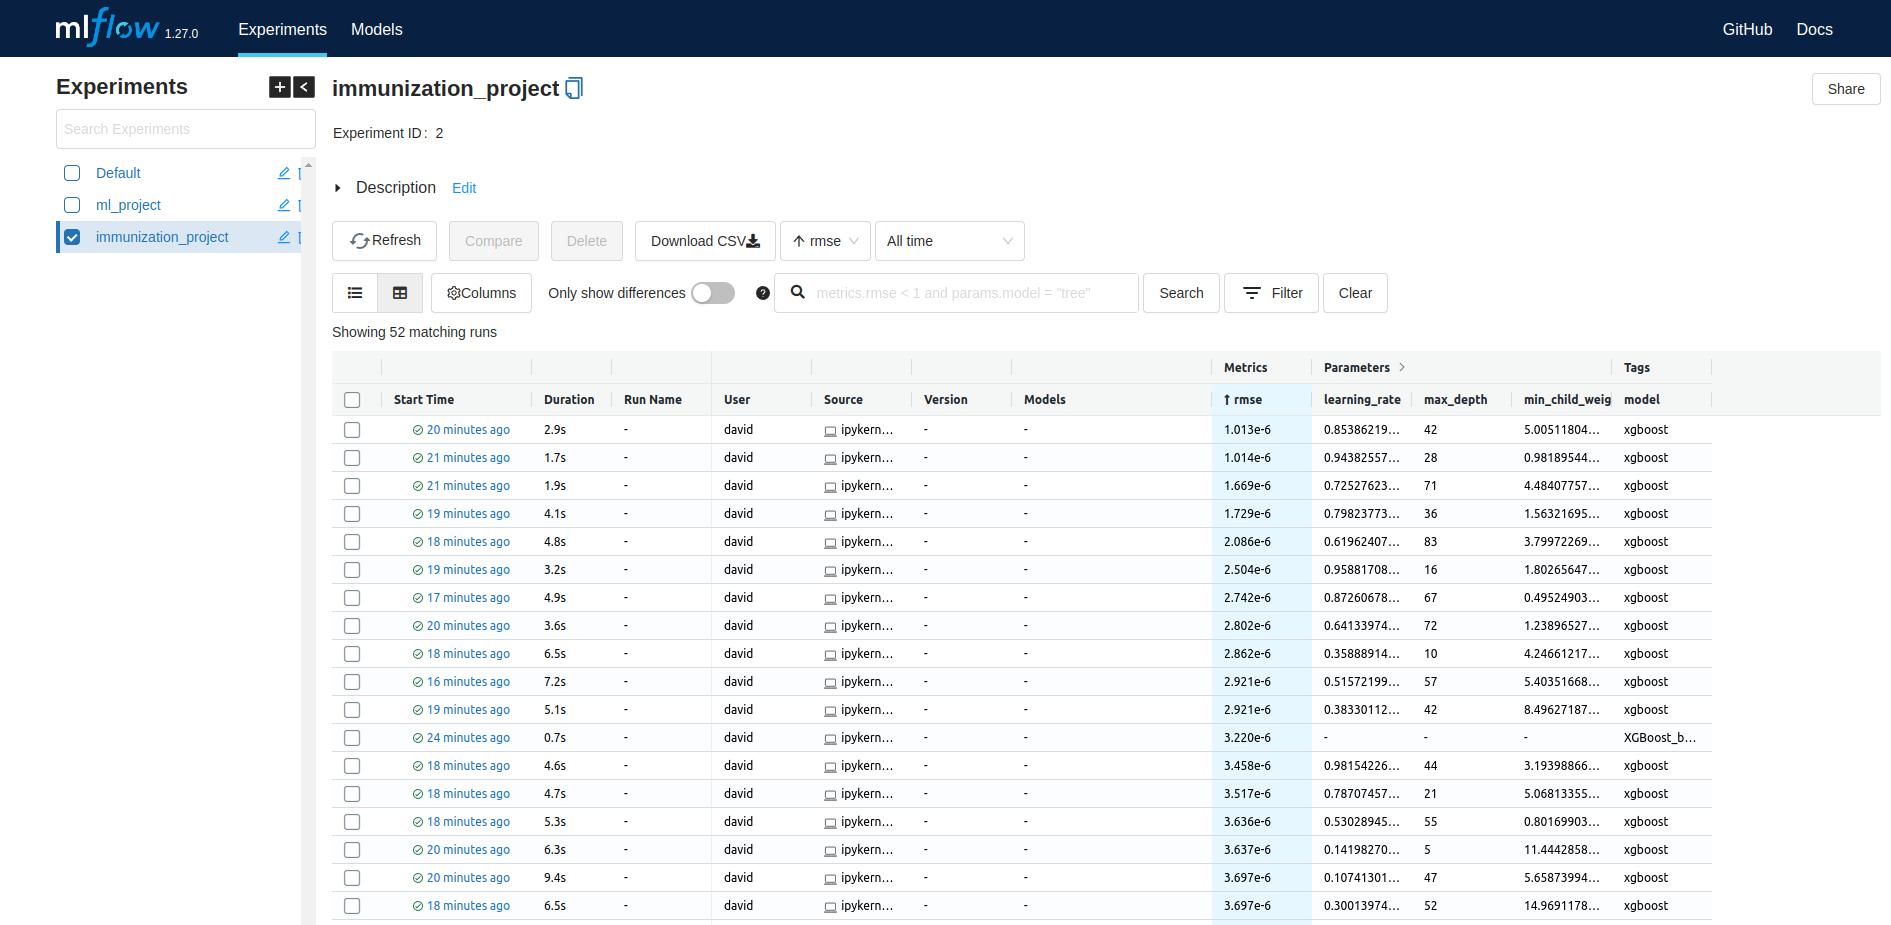

In [61]:
Image(filename='/home/david/Elvis/macro-eyes/ML_Assignment/images/mlflow_immun.png')

The above snapshot shows the different tracked experiments of XGBoost model, plus the parameters logged in

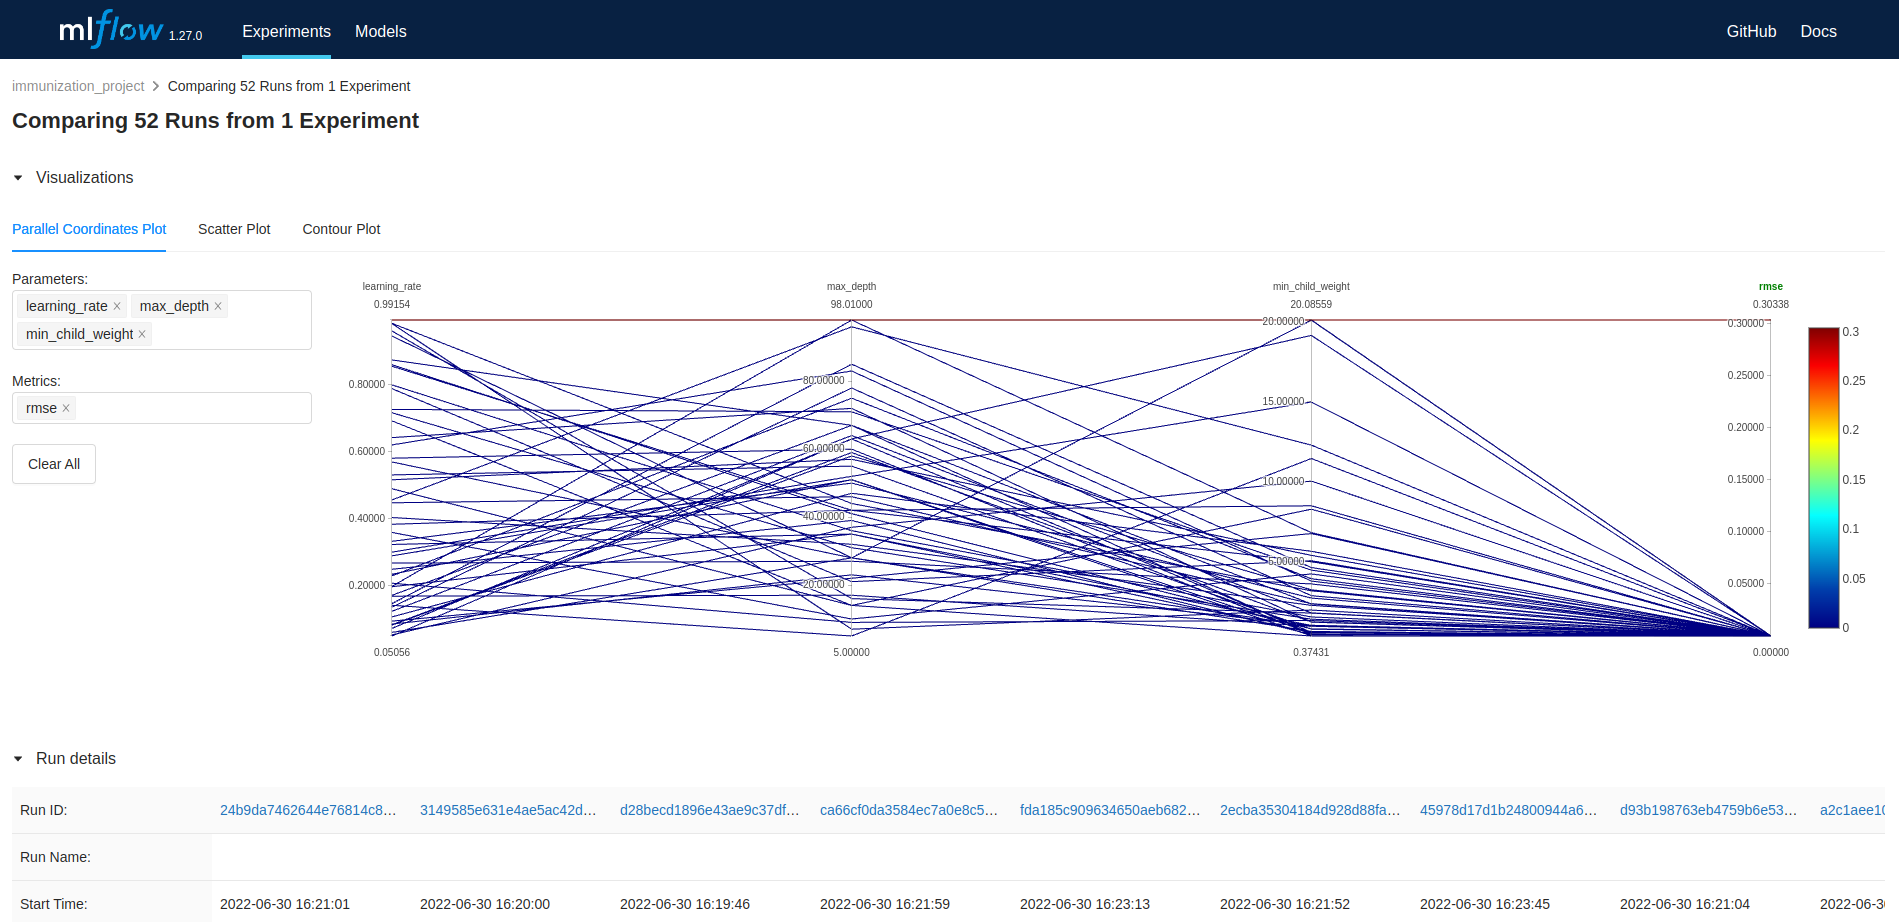

In [62]:
Image(filename='/home/david/Elvis/macro-eyes/ML_Assignment/images/mlflow_immun1.png')

Comparing the different model experiments using parallel coordinates plot

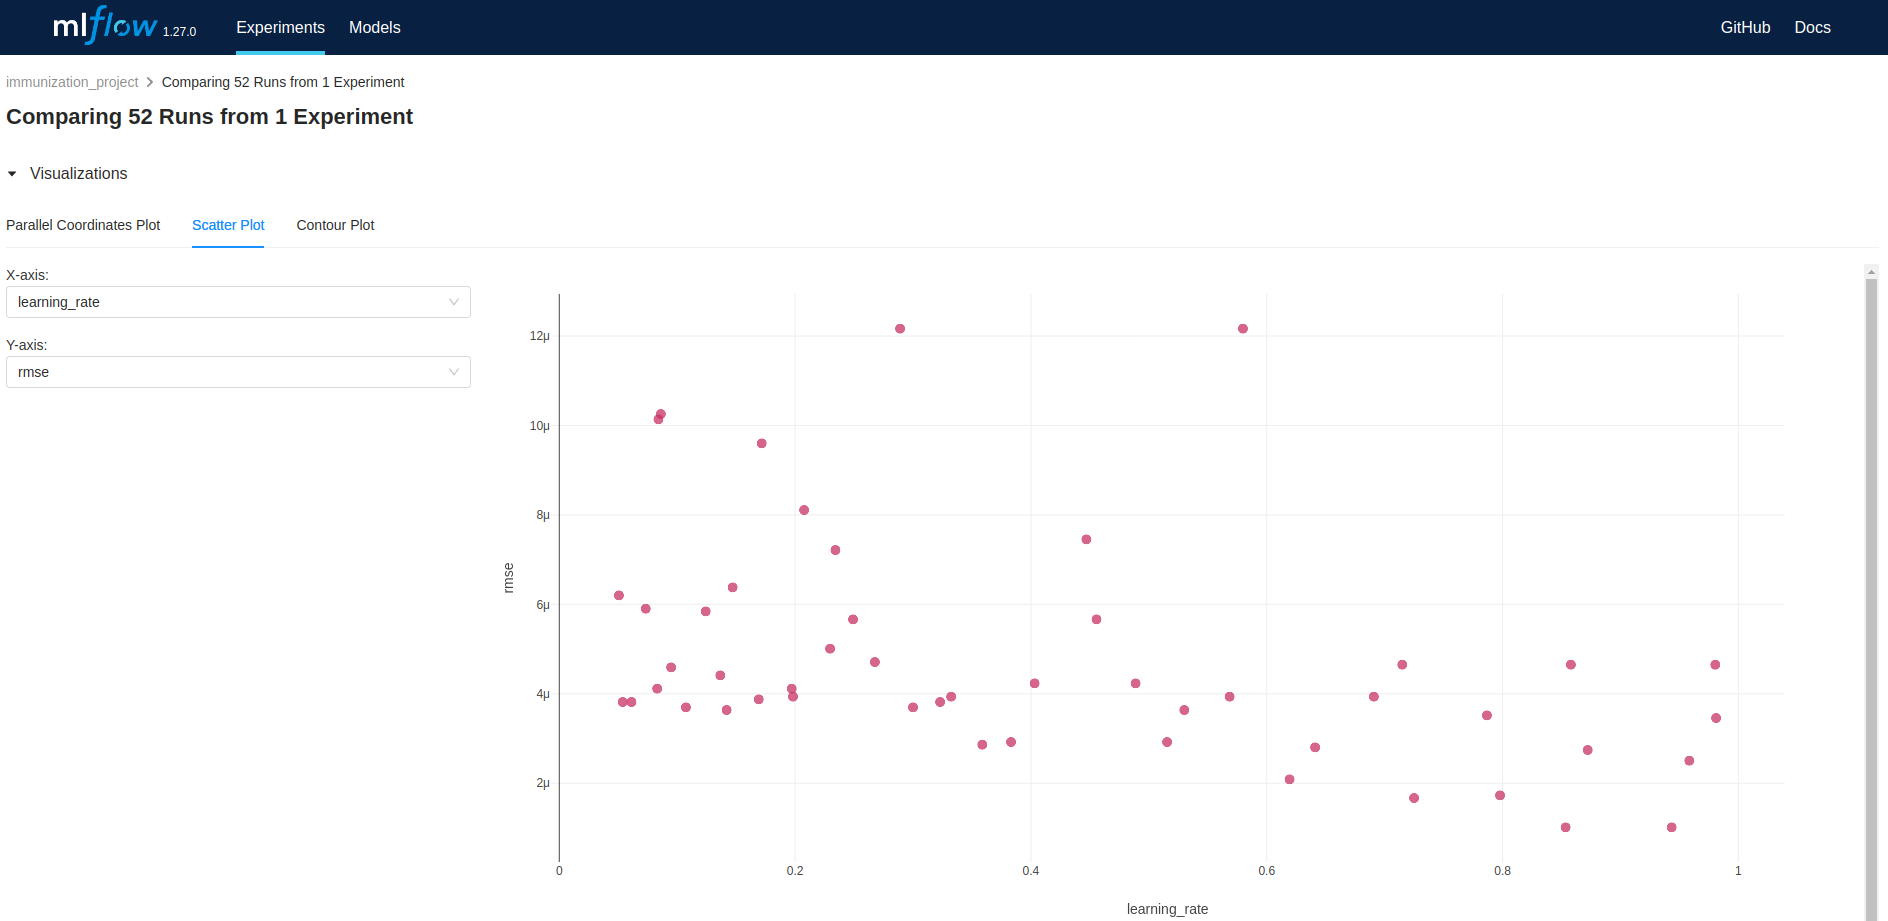

In [63]:
Image(filename='/home/david/Elvis/macro-eyes/ML_Assignment/images/mlflow_immun2.png')

Comparing how different parameters affect each other using the scatter plot

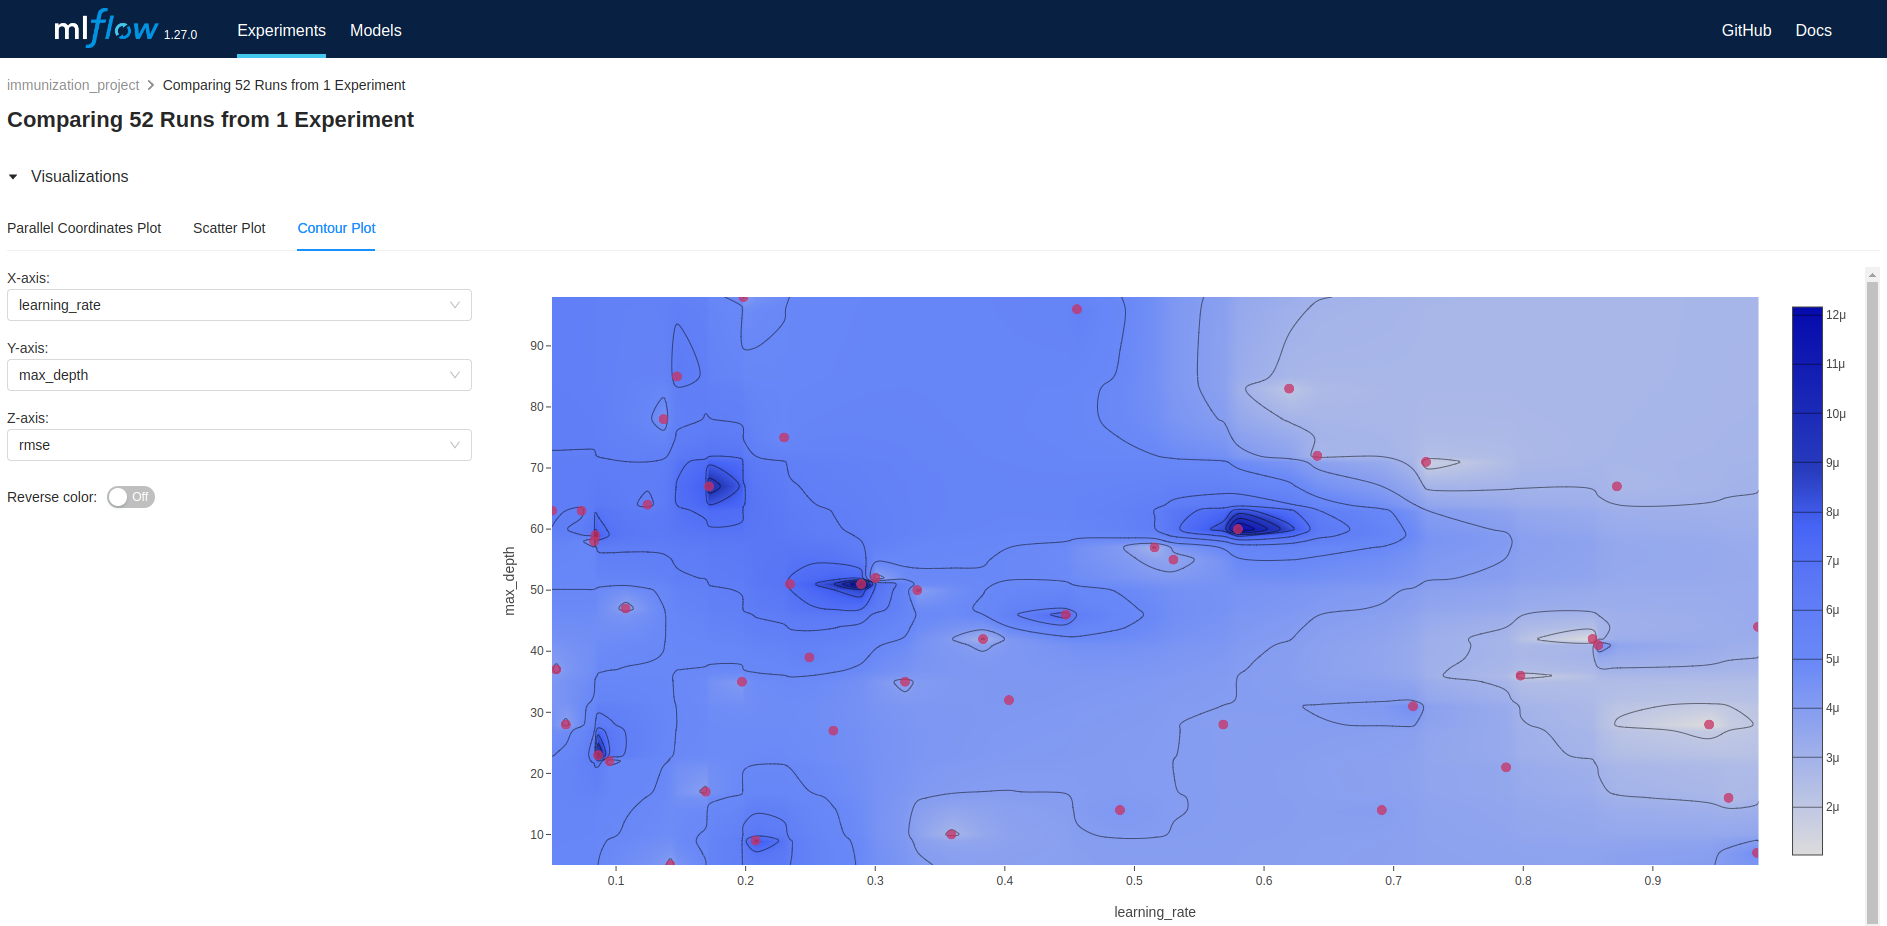

In [64]:
Image(filename='/home/david/Elvis/macro-eyes/ML_Assignment/images/mlflow_immun3.png')

We can also compare three parameters using the contour plot

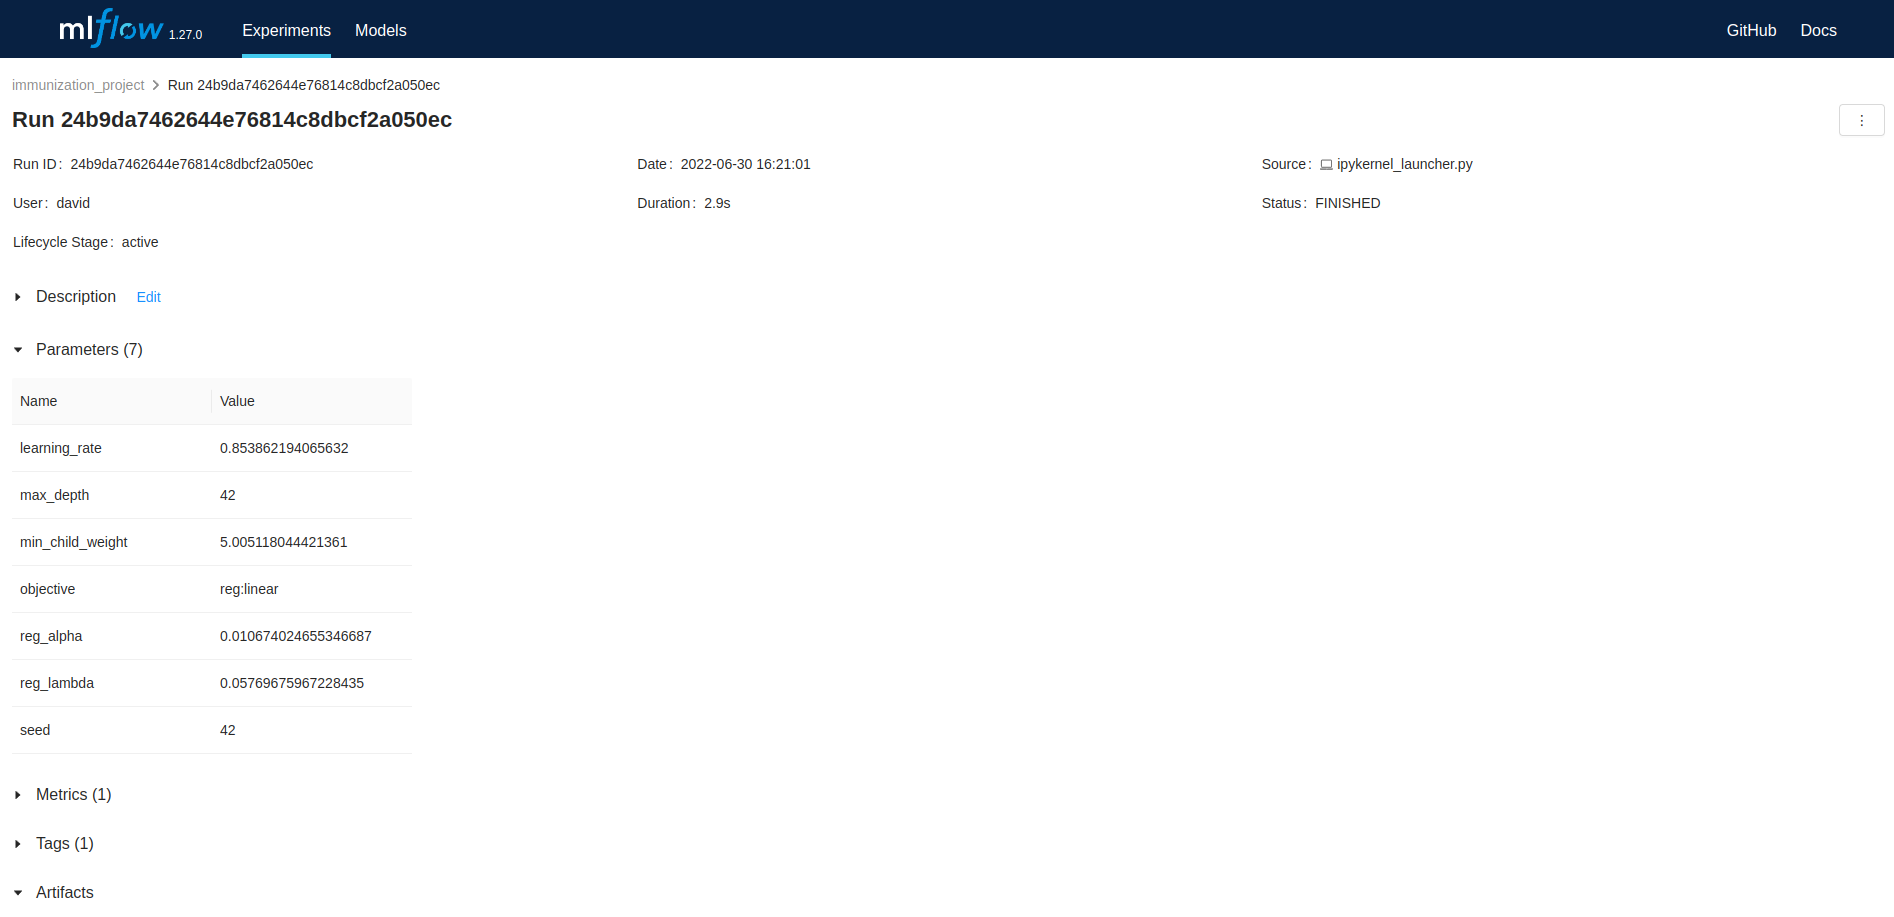

In [65]:
Image(filename='/home/david/Elvis/macro-eyes/ML_Assignment/images/mlflow_immun4.png')

This are the parameters of the best performing model 

In [85]:
params={
    "learning_rate":	0.853862194065632,
    "max_depth":	42,
    "min_child_weight":	5.005118044421361,
    "objective":	'reg:linear',
    "reg_alpha":	0.010674024655346687,
    "reg_lambda":	0.05769675967228435,
    "seed":	42,
}

mlflow.xgboost.autolog()
# with mlflow.start_run():
#     mlflow.set_tag("model", "Best_xgboost_model")
#     mlflow.log_params(params)

    booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )

In [86]:
data

,pat_id,fac_id,dob,gender,long,lat,region,district,im_date,successful,reason_unsuccesful,DTP,OPV
1,2,89.0,2019-11-12,f,24.877556,-18.370709,Chobe,Chobe,2019-11-12,True,0,0,1
2,3,161.0,2019-11-03,m,25.249672,-20.490189,Central,Tutume,2019-11-03,True,0,1,2
3,4,168.0,2019-04-17,f,25.579269,-21.412151,Central,Lethlakane,2019-06-01,True,0,3,4
4,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli,2018-12-24,True,0,2,4
5,6,142.0,2018-09-06,f,26.241089,-20.298571,Central,Tutume,2018-09-06,True,0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,49995,221.0,2018-01-26,f,27.470027,-21.435094,Central,Serowe,2018-02-26,True,0,2,4
48838,49996,191.0,2019-06-17,f,28.551843,-22.495365,Central,Tuli,2019-06-17,True,0,2,3
48840,49998,173.0,2018-10-09,f,22.709613,-20.463382,North-West,Ngamiland West,2018-10-17,True,0,3,4
48841,49999,333.0,2018-08-26,m,23.356211,-20.074906,North-West,Ngamiland East,2018-08-26,True,0,3,4


## Future improvements

- Well defined pipeline using kedro which facilitates the prototyping of data pipelines, and can be integrated with mlflow which manages the lifecycle of machine learning models

- Deploying the model wrapped in docker 

- Using the data to build a streamlit dashboard where the health clinic officers can interact with